## Деревья решений и ансамбли

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV,\
                                    KFold,\
                                    cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, \
                         DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import classification_report,\
                            accuracy_score,\
                            mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier,\
                             AdaBoostClassifier,\
                             RandomForestClassifier,\
                             BaggingClassifier,\
                             StackingClassifier,\
                             GradientBoostingRegressor,\
                             AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier,\
                    XGBRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier,\
                     LGBMRegressor
import math
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/Users/DNS/.cache/kagglehub/datasets/henriqueyamahata/bank-marketing/versions/1/bank-additional-full.csv', sep = ';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Данные связаны с прямыми маркетинговыми кампаниями (телефонные звонки) португальского банковского учреждения. Цель классификации — предсказать, подпишется ли клиент на срочный депозит (переменная y).

Поля:
1. Возраст клиента
2. Занятость (Профессия)
3. Семейное положение
4. Образование
5. Наличие кредита
6. Наличие жилья
7. Наличие ссуды (?loan?)
8. Тип связи
9. Месяц (последний контакт)
10. День недели (последний контакт)
11. Длительность последнего звонка
12. Компания (количество совершенных звонков для этого клиента в рамках этой кампании)
13. Количество дней, прошедших со времени последнего контакта (999 - контакта ранее не было)
14. Количество контактов, выполненных для этого клиента до текущей кампании
15. Результат предыдущей кампании
16. Темп изменения занятости
17. Индекс потребительских цен
18. Индекс потребительской уверенности
19. Ставка за 3 месяца (???)
20. Количество сотрудников (???)
21. Целевая метка - подписался клиент на срочный депозит или нет

In [4]:
data = data.drop(['day_of_week', 'month'], axis = 1)

In [5]:
data.y = data.y.apply(lambda x: 0 if x=='no'\
                  else 1)
data.contact = data.contact.apply(lambda x: 0 if x == 'telephone'\
                                  else 1)

data.job = data.job.apply(lambda x: -1 if x == 'unknown'\
                          else 1 if x == 'unemployed'\
                          else 2 if x == 'housemaid'\
                          else 3 if x == 'services'\
                          else 4 if x == 'admin.'\
                          else 5 if x == 'blue-collar'\
                          else 6 if x == 'technician'\
                          else 7 if x == 'retired'\
                          else 8 if x == 'management'\
                          else 9 if x == 'self-employed'\
                          else 10 if x == 'entrepreneur'\
                          else 11)

data.marital = data.marital.apply(lambda x: -1 if x == 'unknown'\
                                 else 1 if x == 'married'\
                                 else 2 if x == 'single'\
                                 else 3)

data.education = data.education.apply(lambda x: -1 if x == 'unknown'\
                                     else 1 if x in ('basic.4y', 'basic.6y', 'basic.9y')\
                                     else 2 if x == 'high.school'\
                                     else 3 if x == 'professional.course'\
                                     else 4 if x == 'university.degree'\
                                     else 5)

data.default = data.default.apply(lambda x: 0 if x == 'no'\
                              else 1 if x=='yes'\
                              else -1)

data.housing = data.housing.apply(lambda x: 0 if x == 'no'\
                              else 1 if x == 'yes'\
                              else -1)

data.loan = data.loan.apply(lambda x: 0 if x == 'no'\
                        else 1 if x == 'yes'\
                        else -1)

data.poutcome = data.poutcome.apply(lambda x: 0 if x == 'failure'\
                                else 2 if x == 'success'\
                                else -1)

data.pdays = data.pdays.apply(lambda x: -1 if x==999\
                          else 1 if x<=10\
                          else 2 if x<=20\
                          else 3)

In [6]:
data_columns = data.columns

In [7]:
n_scaler = MinMaxScaler()
data_norm = n_scaler.fit_transform(data)

data = pd.DataFrame(data_norm, columns = data_columns)
data.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,0.250000,0.5,0.333333,0.5,0.5,0.5,0.0,0.053070,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
1,0.493827,0.333333,0.5,0.500000,0.0,0.5,0.5,0.0,0.030297,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
2,0.246914,0.333333,0.5,0.500000,0.5,1.0,0.5,0.0,0.045954,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
3,0.283951,0.416667,0.5,0.333333,0.5,0.5,0.5,0.0,0.030704,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
4,0.481481,0.333333,0.5,0.500000,0.5,0.5,1.0,0.0,0.062424,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,0.284248,0.128657,0.0,0.185185,0.259259,0.370370,1.0
job,41188.0,0.519409,0.180056,0.0,0.416667,0.500000,0.583333,1.0
marital,41188.0,0.625231,0.174215,0.0,0.500000,0.500000,0.750000,1.0
education,41188.0,0.548262,0.230408,0.0,0.333333,0.500000,0.833333,1.0
default,41188.0,0.395673,0.203265,0.0,0.500000,0.500000,0.500000,1.0
housing,41188.0,0.749903,0.272983,0.0,0.500000,1.000000,1.000000,1.0
loan,41188.0,0.563829,0.199648,0.0,0.500000,0.500000,0.500000,1.0
contact,41188.0,0.634748,0.481507,0.0,0.000000,1.000000,1.000000,1.0
duration,41188.0,0.052518,0.052720,0.0,0.020740,0.036600,0.064864,1.0
campaign,41188.0,0.028502,0.050364,0.0,0.000000,0.018182,0.036364,1.0


In [9]:
X = data.drop('y', axis = 1)
y = data.y

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [11]:
svc_rbf = SVC(kernel = 'rbf', probability = True)
svc_rbf.fit(X_train, y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

print(f'SVC(rbf) Accuracy: {round(accuracy_score(y_test, svc_rbf_pred), 3)*100} %')

SVC(rbf) Accuracy: 90.2 %


Реализовать решение задачи классификации пользовательских данных с использованием деревьев решений. Сравнить с ранее применявшимися методами.

In [24]:
dtree_g = DecisionTreeClassifier()
dtree_g.fit(X_train, y_train)
dtree_g_pred = dtree_g.predict(X_test)

print(f'Decision Tree Classification(gini) Accuracy: {round(accuracy_score(y_test, dtree_g_pred), 2)*100}')

Decision Tree Classification(gini) Accuracy: 89.0


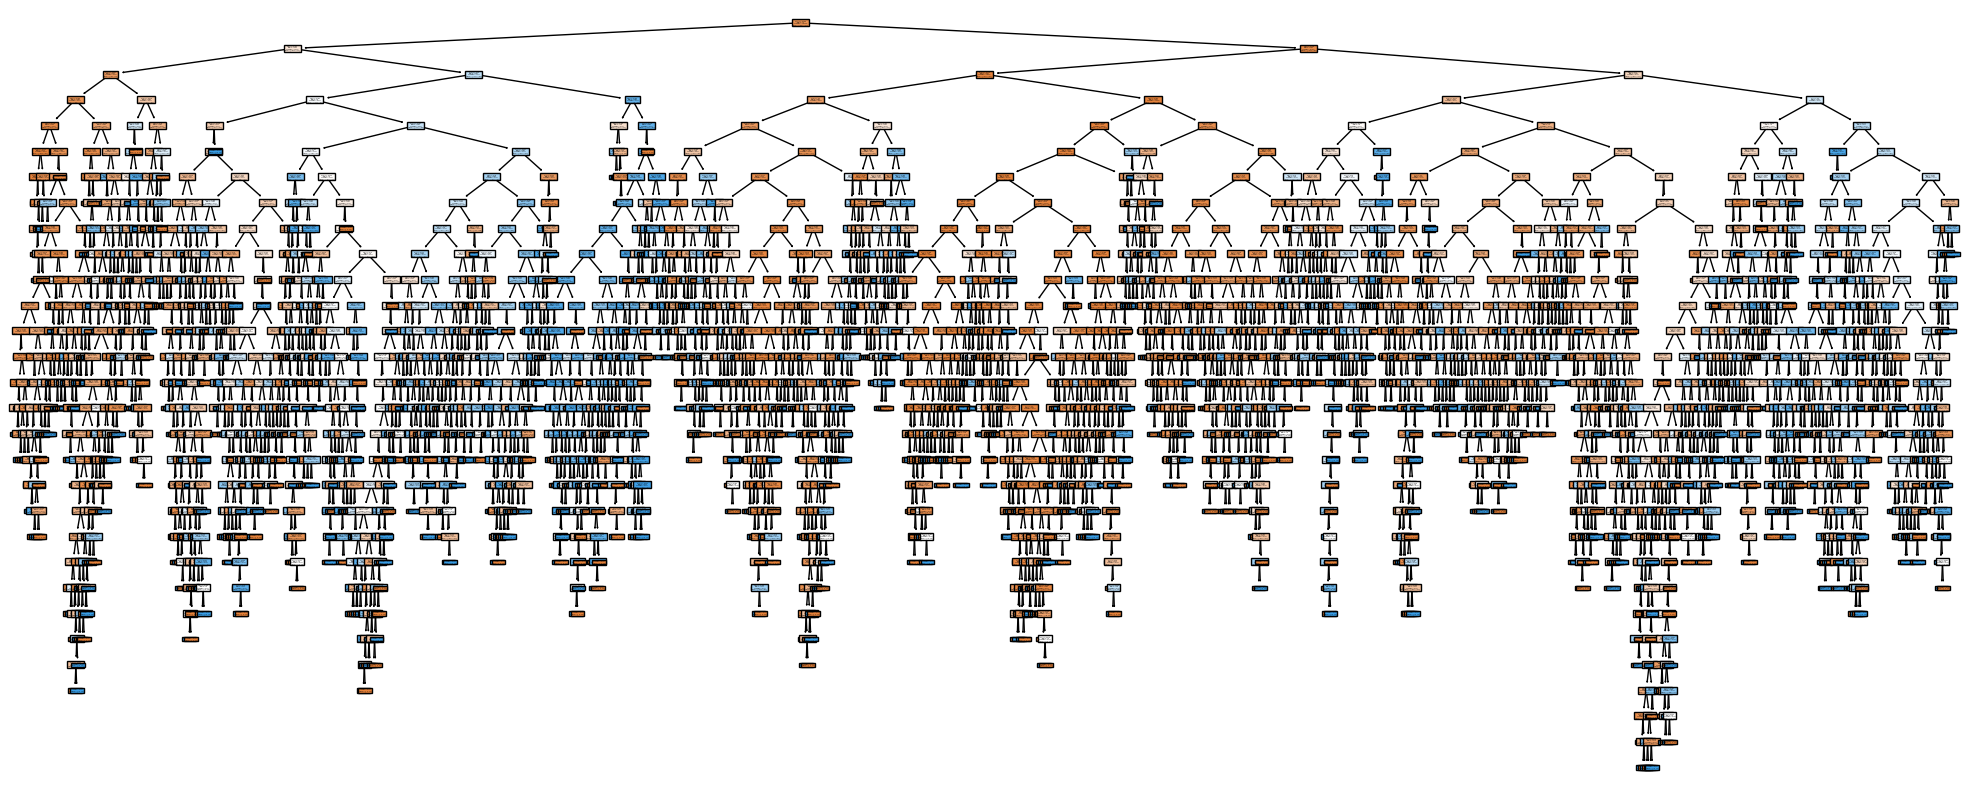

In [25]:
fig = plt.figure(figsize = (25,10))
tree.plot_tree(dtree_g, filled = True, proportion = True)
plt.show()

In [29]:
params = [{'criterion':['gini'], 'min_samples_leaf':[5, 10, 20, 50, 100], 'max_depth':[5, 10, 20, 50, 100]}]
grid_search = GridSearchCV(estimator = dtree_g,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_params}')

Accuracy: 91.0
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}


In [31]:
dtree_g = DecisionTreeClassifier(criterion = 'gini',
                                 max_depth = 5,
                                 min_samples_leaf = 10)
dtree_g.fit(X_train, y_train)
dtree_g_pred = dtree_g.predict(X_test)

print(f'Decision Tree Classification(gini) Accuracy: {round(accuracy_score(y_test, dtree_g_pred), 2)*100}')

Decision Tree Classification(gini) Accuracy: 92.0


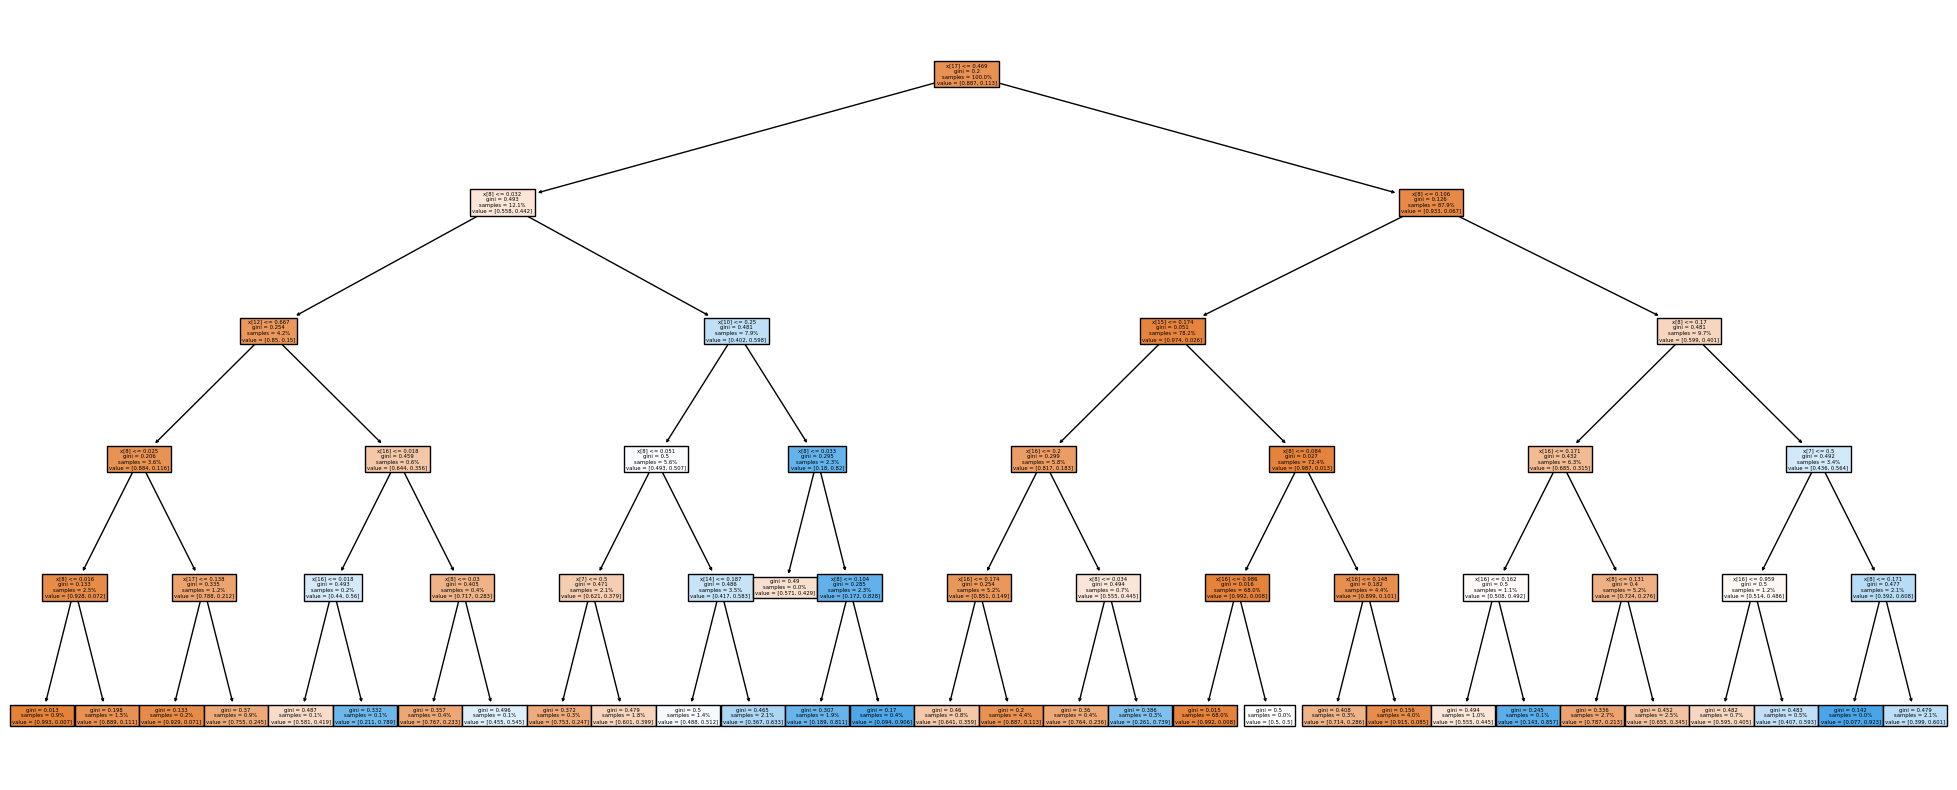

In [33]:
fig = plt.figure(figsize = (25,10))
tree.plot_tree(dtree_g, filled = True, proportion = True)
plt.show()

#fontsize

In [35]:
#fig.savefig("dtree_g.png")

In [120]:
test_data = X_test.copy()
test_data['y_test'] = y_test

In [125]:
test_data['DTree_gini'] = dtree_g_pred

In [39]:
dtree_e = DecisionTreeClassifier()
dtree_e.fit(X_train, y_train)
dtree_e_pred = dtree_e.predict(X_test)

print(f'Decision Tree Classification(entropy) Accuracy: {round(accuracy_score(y_test, dtree_e_pred), 2)*100}')

Decision Tree Classification(entropy) Accuracy: 89.0


In [41]:
params = [{'criterion':['entropy'], 'min_samples_leaf':[5, 10, 20, 50, 100], 'max_depth':[5, 10, 20, 50, 100]}]
grid_search = GridSearchCV(estimator = dtree_e,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_params}')

Accuracy: 91.0
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}


In [43]:
dtree_e = DecisionTreeClassifier(criterion = 'entropy',
                                 max_depth = 5,
                                 min_samples_leaf = 20)
dtree_e.fit(X_train, y_train)
dtree_e_pred = dtree_e.predict(X_test)

print(f'Decision Tree Classification(entropy) Accuracy: {round(accuracy_score(y_test, dtree_e_pred), 2)*100}')

Decision Tree Classification(entropy) Accuracy: 92.0


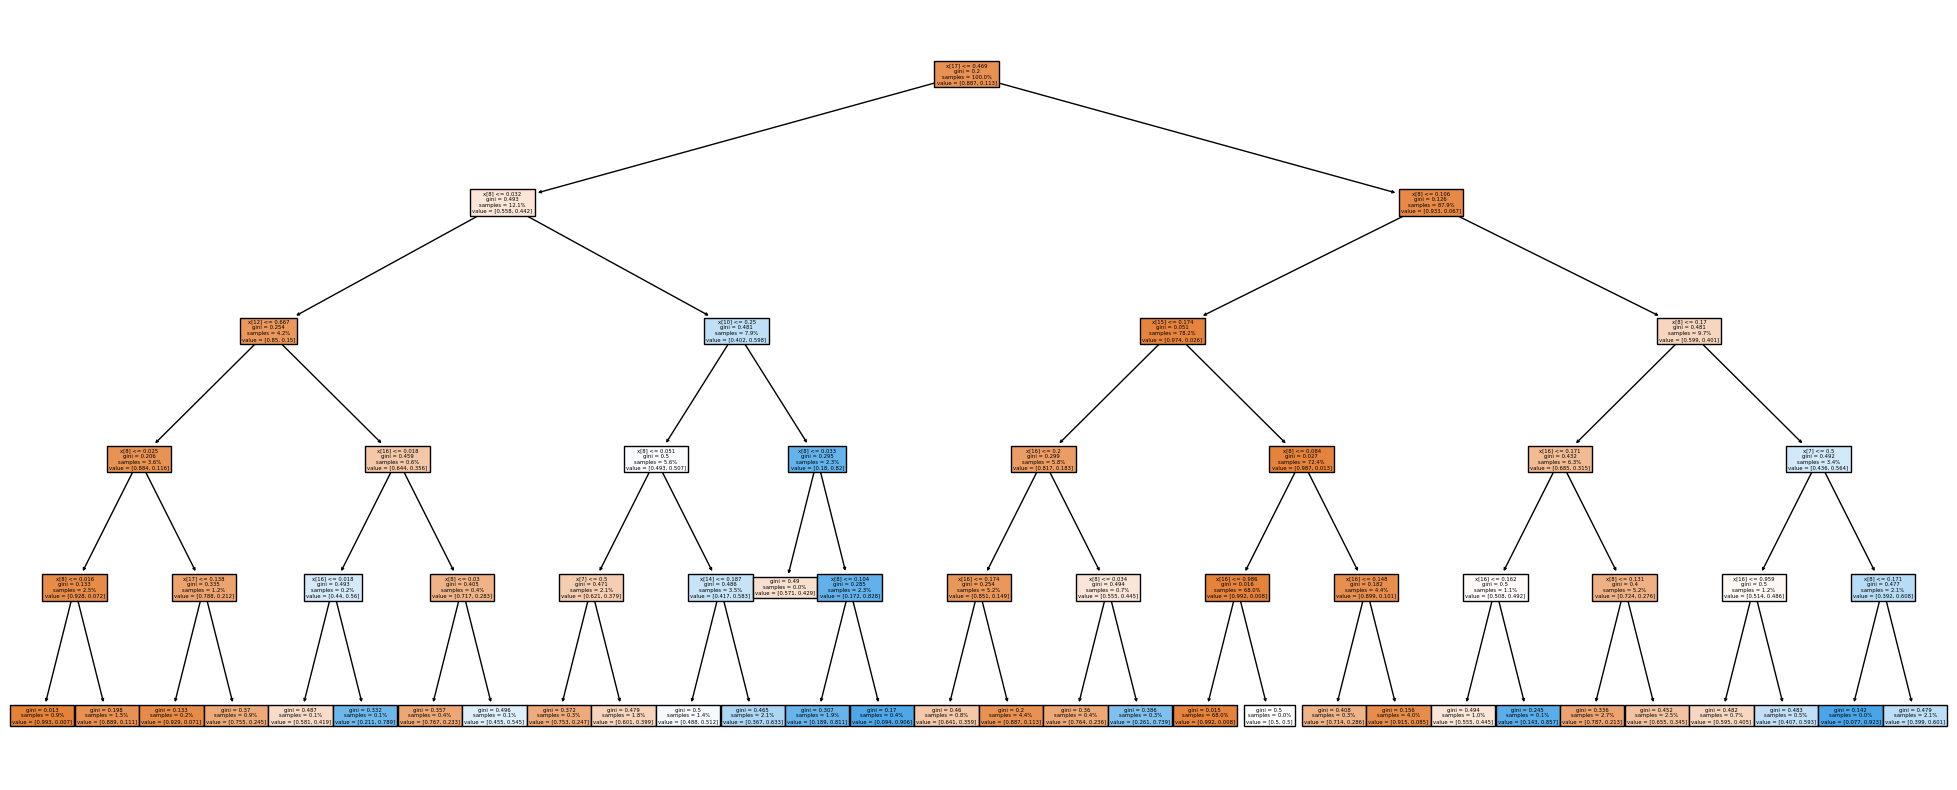

In [45]:
fig = plt.figure(figsize = (25,10))
tree.plot_tree(dtree_g, filled = True, proportion = True)
plt.show()

In [123]:
#fig.savefig("dtree_e.png")

In [127]:
test_data['DTree_entropy'] = dtree_e_pred

Реализовать решение задачи регрессии для пользовательских данных с использованием деревьев решений. Сравнить с ранее применявшимися методами.

In [48]:
dtree_reg = DecisionTreeRegressor()
dtree_reg.fit(X_train, y_train)
dtree_reg_pred = dtree_reg.predict(X_test)

print(f'Decision Tree Regressor MSE:{round(mean_squared_error(y_test, dtree_reg_pred), 2)*100}')

Decision Tree Regressor MSE:11.0


Реализовать решение задач классификации и регрессии пользовательских и/или модельных данных с использованием бэггинга над деревьями решений и случайного леса.

In [51]:
bag = BaggingClassifier(estimator = DecisionTreeClassifier(criterion = 'gini',
                                 max_depth = 5,
                                 min_samples_leaf = 10))
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)

print(f'Bagging Accuracy: {round(accuracy_score(y_test, bag_pred), 2)*100}')

Bagging Accuracy: 92.0


In [53]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(f'Random Forest Accuracy: {round(accuracy_score(y_test, rfc_pred), 2)*100}')

Random Forest Accuracy: 92.0


In [129]:
test_data['RForest'] = rfc_pred

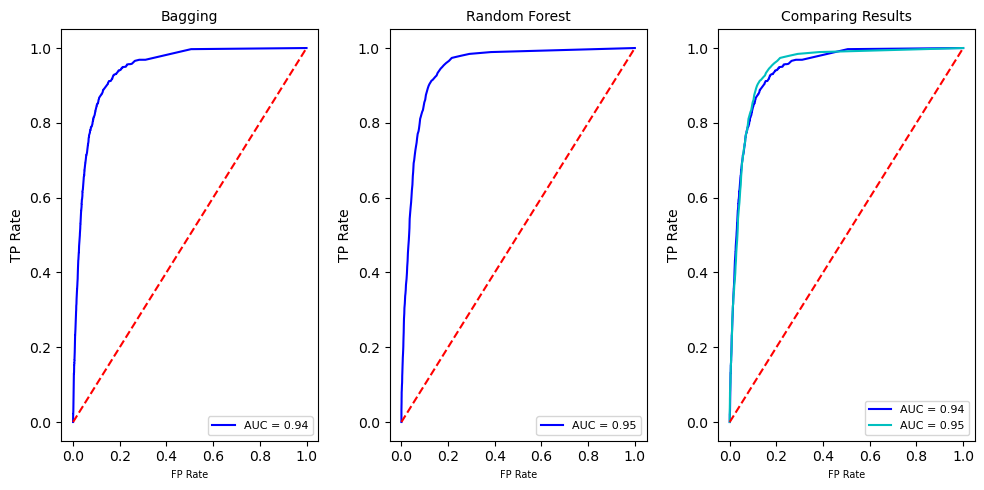

In [54]:
fig, ax_arr = plt.subplots(1,3, figsize = (10,5))

#Bagging
probs = bag.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

plt.subplot(1,3,1)
plt.plot(fprlog, tprlog, 'b', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Bagging',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

#Random Forest
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_test, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

plt.subplot(1,3,2)
plt.plot(fprknn, tprknn, 'b', label = f'AUC = {round(roc_aucknn, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Random Forest',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop={'size': 8})

#All
plt.subplot(1,3,3)
plt.plot(fprlog, tprlog, 'b', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot(fprknn, tprknn, 'c', label = f'AUC = {round(roc_aucknn, 2)}')

plt.plot([0, 1], [0, 1],'r--')
plt.title('Comparing Results',fontsize = 10)
plt.ylabel('TP Rate',fontsize = 10)
plt.xlabel('FP Rate',fontsize = 7)
plt.legend(loc = 'lower right', prop = {'size': 8})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

 Реализовать решение задач классификации и регрессии пользовательских и/или модельных данных с использованием градиентного бустинга, алгоритмов AdaBoost, XGBoost, CatBoost и LightGBM.

In [58]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train, y_train)
grad_boost_pred = grad_boost.predict(X_test)

print(f'Gradient Boosting Accuracy: {round(accuracy_score(y_test, grad_boost_pred), 2)*100}')

Gradient Boosting Accuracy: 92.0


In [131]:
test_data['GradBoost'] = grad_boost_pred

In [59]:
ada_boost = AdaBoostClassifier(n_estimators = 2000)
ada_boost.fit(X_train, y_train)
ada_boost_pred = ada_boost.predict(X_test)

print(f'Ada Boosting Accuracy: {round(accuracy_score(y_test, ada_boost_pred), 2)*100}')

Ada Boosting Accuracy: 92.0


In [61]:
parameters = [{'n_estimators': [50, 100, 200, 300, 500, 1000, 1500, 2000]}] 
grid_search = GridSearchCV(estimator = ada_boost,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(f'Accuracy: {round(best_accuracy, 2)*100}')
print(f'Best Parameters: {best_parameters}')

Accuracy: 91.0
Best Parameters: {'n_estimators': 2000}


In [62]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print(f'XGBoosting Accuracy: {round(accuracy_score(y_test, xgb_pred), 2)*100}')

XGBoosting Accuracy: 92.0


In [133]:
test_data['XGBoost'] = xgb_pred

In [66]:
cat_boost = CatBoostClassifier()
cat_boost.fit(X_train, y_train)
cat_boost_pred = cat_boost.predict(X_test)

print(f'CatBoosting Accuracy: {round(accuracy_score(y_test, cat_boost_pred), 2)*100}')

Learning rate set to 0.045328
0:	learn: 0.6320207	total: 222ms	remaining: 3m 42s
1:	learn: 0.5792438	total: 253ms	remaining: 2m 6s
2:	learn: 0.5245480	total: 278ms	remaining: 1m 32s
3:	learn: 0.4797928	total: 297ms	remaining: 1m 13s
4:	learn: 0.4357457	total: 312ms	remaining: 1m 2s
5:	learn: 0.4078104	total: 327ms	remaining: 54.2s
6:	learn: 0.3736053	total: 342ms	remaining: 48.6s
7:	learn: 0.3524924	total: 357ms	remaining: 44.3s
8:	learn: 0.3305599	total: 371ms	remaining: 40.8s
9:	learn: 0.3150036	total: 383ms	remaining: 37.9s
10:	learn: 0.3027653	total: 395ms	remaining: 35.5s
11:	learn: 0.2901340	total: 408ms	remaining: 33.6s
12:	learn: 0.2786995	total: 420ms	remaining: 31.9s
13:	learn: 0.2703395	total: 434ms	remaining: 30.6s
14:	learn: 0.2621485	total: 446ms	remaining: 29.3s
15:	learn: 0.2549955	total: 462ms	remaining: 28.4s
16:	learn: 0.2476545	total: 478ms	remaining: 27.6s
17:	learn: 0.2430882	total: 490ms	remaining: 26.7s
18:	learn: 0.2365274	total: 502ms	remaining: 25.9s
19:	lear

In [135]:
test_data['CatBoost'] = cat_boost_pred

In [68]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

print(f'LightGBM Accuracy: {round(accuracy_score(y_test, lgbm_pred), 2)*100}')

[LightGBM] [Info] Number of positive: 3620, number of negative: 28506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 32126, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112681 -> initscore=-2.063641
[LightGBM] [Info] Start training from score -2.063641
LightGBM Accuracy: 92.0


In [137]:
test_data['LightGBM'] = lgbm_pred

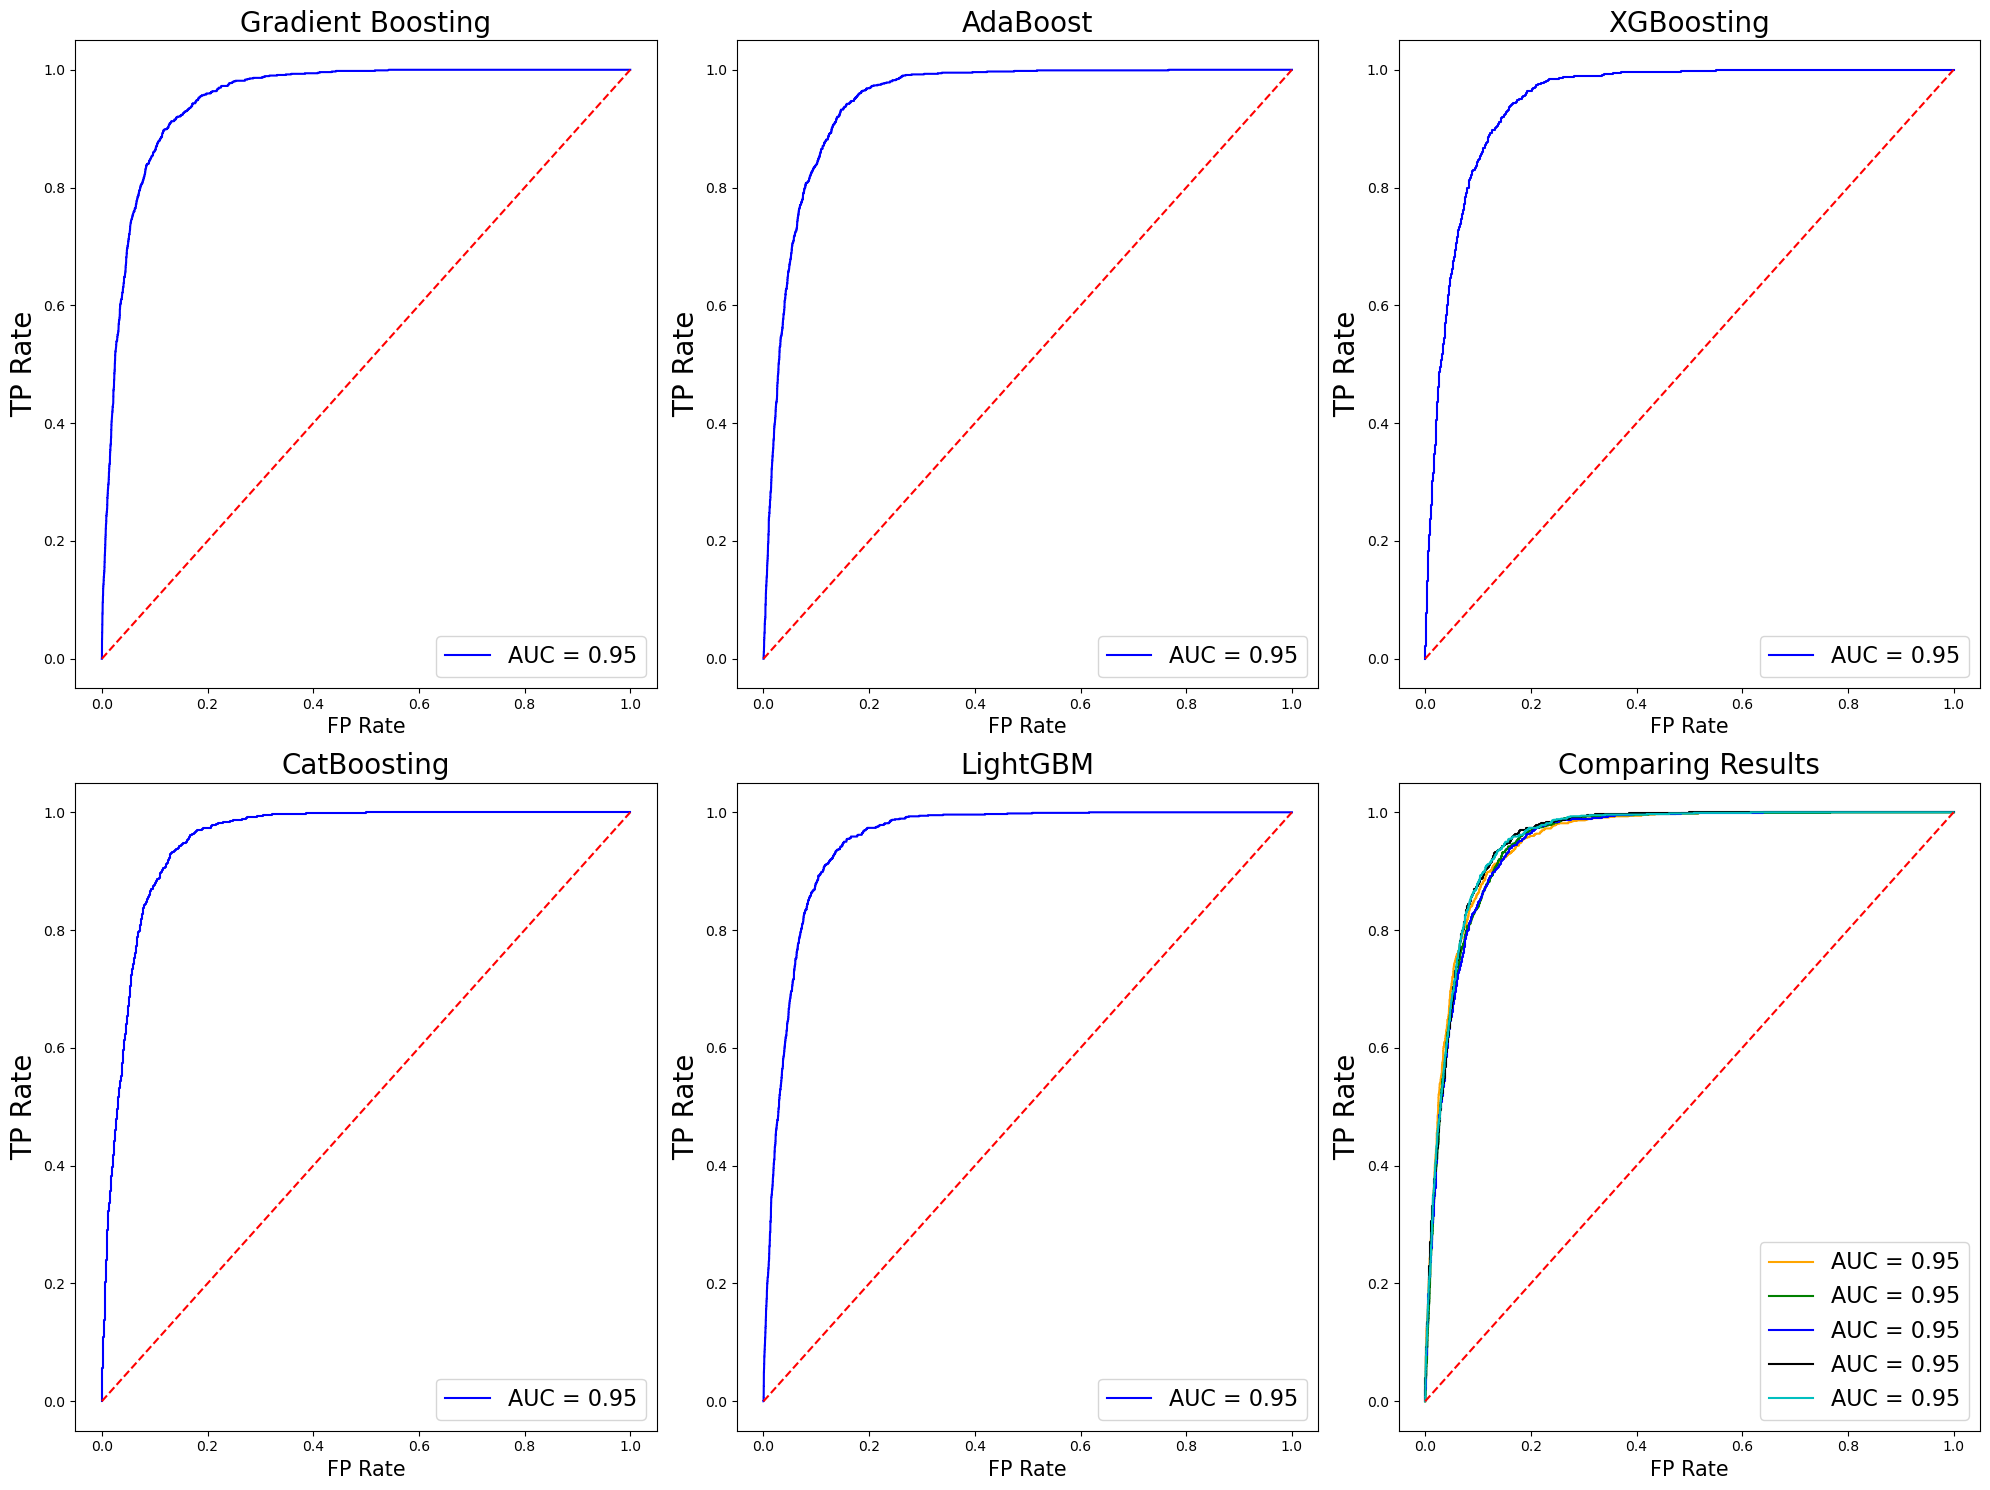

In [69]:
fig, ax_arr = plt.subplots(2,3, figsize = (20,15))

#Градиентный бустинг
probs = grad_boost.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

plt.subplot(2,3,1)
plt.plot(fprlog, tprlog, 'b', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('Gradient Boosting',fontsize = 20)
plt.ylabel('TP Rate',fontsize=20)
plt.xlabel('FP Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

#Ada_boost
probs = ada_boost.predict_proba(X_test)
preds = probs[:,1]
fprknn, tprknn, thresholdknn = metrics.roc_curve(y_test, preds)
roc_aucknn = metrics.auc(fprknn, tprknn)

plt.subplot(2,3,2)
plt.plot(fprknn, tprknn, 'b', label = f'AUC = {round(roc_aucknn, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('AdaBoost',fontsize = 20)
plt.ylabel('TP Rate',fontsize=20)
plt.xlabel('FP Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

#XGB
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fprsvc_l, tprsvc_l, thresholdsvc_l = metrics.roc_curve(y_test, preds)
roc_aucsvc_l = metrics.auc(fprsvc_l, tprsvc_l)

plt.subplot(2,3,3)
plt.plot(fprsvc_l, tprsvc_l, 'b', label = f'AUC = {round(roc_aucsvc_l, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('XGBoosting',fontsize = 20)
plt.ylabel('TP Rate',fontsize=20)
plt.xlabel('FP Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

#Cat_boost
probs = cat_boost.predict_proba(X_test)
preds = probs[:,1]
fprsvc_p, tprsvc_p, thresholdsvc_p = metrics.roc_curve(y_test, preds)
roc_aucsvc_p = metrics.auc(fprsvc_p, tprsvc_p)

plt.subplot(2,3,4)
plt.plot(fprsvc_p, tprsvc_p, 'b', label = f'AUC = {round(roc_aucsvc_p, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('CatBoosting',fontsize = 20)
plt.ylabel('TP Rate',fontsize=20)
plt.xlabel('FP Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

#LGBM
probs = lgbm.predict_proba(X_test)
preds = probs[:,1]
fprsvc_rbf, tprsvc_rbf, thresholdsvc_rbf = metrics.roc_curve(y_test, preds)
roc_aucsvc_rbf = metrics.auc(fprsvc_rbf, tprsvc_rbf)

plt.subplot(2,3,5)
plt.plot(fprsvc_rbf, tprsvc_rbf, 'b', label = f'AUC = {round(roc_aucsvc_rbf, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.title('LightGBM',fontsize = 20)
plt.ylabel('TP Rate',fontsize=20)
plt.xlabel('FP Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})

#All
plt.subplot(2,3,6)
plt.plot(fprlog, tprlog, 'orange', label = f'AUC = {round(roc_auclog, 2)}')
plt.plot(fprknn, tprknn, 'g', label = f'AUC = {round(roc_aucknn, 2)}')
plt.plot(fprsvc_l, tprsvc_l, 'b', label = f'AUC = {round(roc_aucsvc_l, 2)}')
plt.plot(fprsvc_p, tprsvc_p, 'k', label = f'AUC = {round(roc_aucsvc_p, 2)}')
plt.plot(fprsvc_rbf, tprsvc_rbf, 'c', label = f'AUC = {round(roc_aucsvc_rbf, 2)}')

plt.plot([0, 1], [0, 1],'r--')
plt.title('Comparing Results',fontsize = 20)
plt.ylabel('TP Rate',fontsize = 20)
plt.xlabel('FP Rate',fontsize = 15)
plt.legend(loc = 'lower right', prop = {'size': 16})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

In [72]:
grad_reg = GradientBoostingRegressor()
grad_reg.fit(X_train, y_train)
grad_reg_pred = grad_reg.predict(X_test)

print(f'Gradient Boosting Regressor MSE:{round(mean_squared_error(y_test, grad_reg_pred), 2)*100}')

Gradient Boosting Regressor MSE:5.0


In [74]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)
ada_reg_pred = ada_reg.predict(X_test)

print(f'AdaBoosting Regressor MSE:{round(mean_squared_error(y_test, ada_reg_pred), 2)*100}')

AdaBoosting Regressor MSE:8.0


In [76]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg_pred = xgb_reg.predict(X_test)

print(f'XGBoosting Regressor MSE:{round(mean_squared_error(y_test, xgb_reg_pred), 2)*100}')

XGBoosting Regressor MSE:6.0


In [78]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train, y_train)
lgbm_reg_pred = lgbm_reg.predict(X_test)

print(f'LGBM Regressor MSE:{round(mean_squared_error(y_test, lgbm_reg_pred), 2)*100}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 32126, number of used features: 18
[LightGBM] [Info] Start training from score 0.112681
LGBM Regressor MSE:5.0


Реализовать решение задач классификации и/или регрессии пользовательских и/или модельных данных с использованием стекинга.

In [22]:
est = [('rfc', RandomForestClassifier()),
       ('svc', SVC(kernel = 'rbf'))]

stacking = StackingClassifier(estimators = est, final_estimator = LogisticRegression())
stacking.fit(X_train, y_train)
stacking_pred = stacking.predict(X_test)

print(f'Stacking Classifier Accuracy: {round(accuracy_score(y_test, stacking_pred), 2)*100}')

Stacking Classifier Accuracy: 92.0


In [24]:
stacking_2 = StackingClassifier(estimators = [('stacking_1', stacking)],\
                                final_estimator = KNeighborsClassifier(n_neighbors = 22))

stacking_2.fit(X_train, y_train)
stacking_2_pred = stacking_2.predict(X_test)

print(f'Stacking 2 level Classifier Accuracy: {round(accuracy_score(y_test,\
                                                                    stacking_2_pred), 2)*100}')

Stacking 2 level Classifier Accuracy: 92.0


In [28]:
stacking_3 = StackingClassifier(estimators = [('stacking_2', stacking)],\
                                final_estimator = SVC(kernel = 'rbf'))
                                

stacking_3.fit(X_train, y_train)
stacking_3_pred = stacking_3.predict(X_test)

print(f'Stacking 3 level Classifier Accuracy: {round(accuracy_score(y_test,\
                                                                    stacking_3_pred), 2)*100}')

Stacking 3 level Classifier Accuracy: 92.0


Общее сравнение

In [84]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [88]:
DTREE_g = (cross_val_score(dtree_g, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [90]:
DTREE_e = (cross_val_score(dtree_e, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [92]:
GRAD = (cross_val_score(grad_boost, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [100]:
#ADA = (cross_val_score(ada_boost, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [96]:
XGB = (cross_val_score(xgb, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [98]:
CAT = (cross_val_score(cat_boost, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

Learning rate set to 0.043333
0:	learn: 0.6310160	total: 18.3ms	remaining: 18.3s
1:	learn: 0.5795504	total: 35.6ms	remaining: 17.8s
2:	learn: 0.5300407	total: 52.7ms	remaining: 17.5s
3:	learn: 0.4866008	total: 68.6ms	remaining: 17.1s
4:	learn: 0.4429538	total: 83.3ms	remaining: 16.6s
5:	learn: 0.4149170	total: 97.2ms	remaining: 16.1s
6:	learn: 0.3818606	total: 111ms	remaining: 15.8s
7:	learn: 0.3607514	total: 126ms	remaining: 15.6s
8:	learn: 0.3375966	total: 141ms	remaining: 15.6s
9:	learn: 0.3209275	total: 154ms	remaining: 15.3s
10:	learn: 0.3082052	total: 168ms	remaining: 15.1s
11:	learn: 0.2935414	total: 180ms	remaining: 14.8s
12:	learn: 0.2819494	total: 193ms	remaining: 14.7s
13:	learn: 0.2732786	total: 208ms	remaining: 14.7s
14:	learn: 0.2649008	total: 222ms	remaining: 14.6s
15:	learn: 0.2574948	total: 237ms	remaining: 14.6s
16:	learn: 0.2516124	total: 252ms	remaining: 14.6s
17:	learn: 0.2450318	total: 264ms	remaining: 14.4s
18:	learn: 0.2392229	total: 275ms	remaining: 14.2s
19:	l

In [104]:
LGBM = (cross_val_score(lgbm, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[LightGBM] [Info] Number of positive: 3256, number of negative: 25657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 28913, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112614 -> initscore=-2.064317
[LightGBM] [Info] Start training from score -2.064317
[LightGBM] [Info] Number of positive: 3277, number of negative: 25636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 28913, number of used features: 18
[LightGBM] [Info] [bin

In [106]:
RFC = (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [ ]:
#SVC_RBF = (cross_val_score(svc_rbf, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [112]:
models = pd.DataFrame({'Models': ['Decision Tree (gini)','Decision Tree (entropy)','Gradient Boosting','XGBoosting','CatBoost','LightGBM', 'Random Forest'],\
                       'Score':[DTREE_g, DTREE_e, GRAD, XGB, CAT, LGBM, RFC]})
models.sort_values(by = 'Score', ascending = False)

,Models,Score
5,LightGBM,0.916485
4,CatBoost,0.914959
2,Gradient Boosting,0.914212
0,Decision Tree (gini),0.913372
6,Random Forest,0.912625
3,XGBoosting,0.912127
1,Decision Tree (entropy),0.911784


<Axes: xlabel='duration', ylabel='age'>

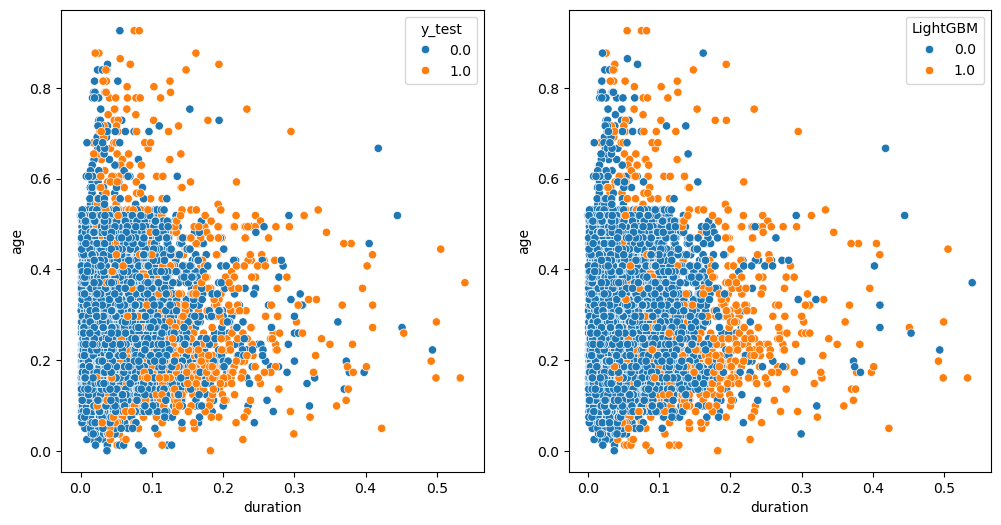

In [158]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "y_test")

plt.subplot(1, 2, 2)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "LightGBM")

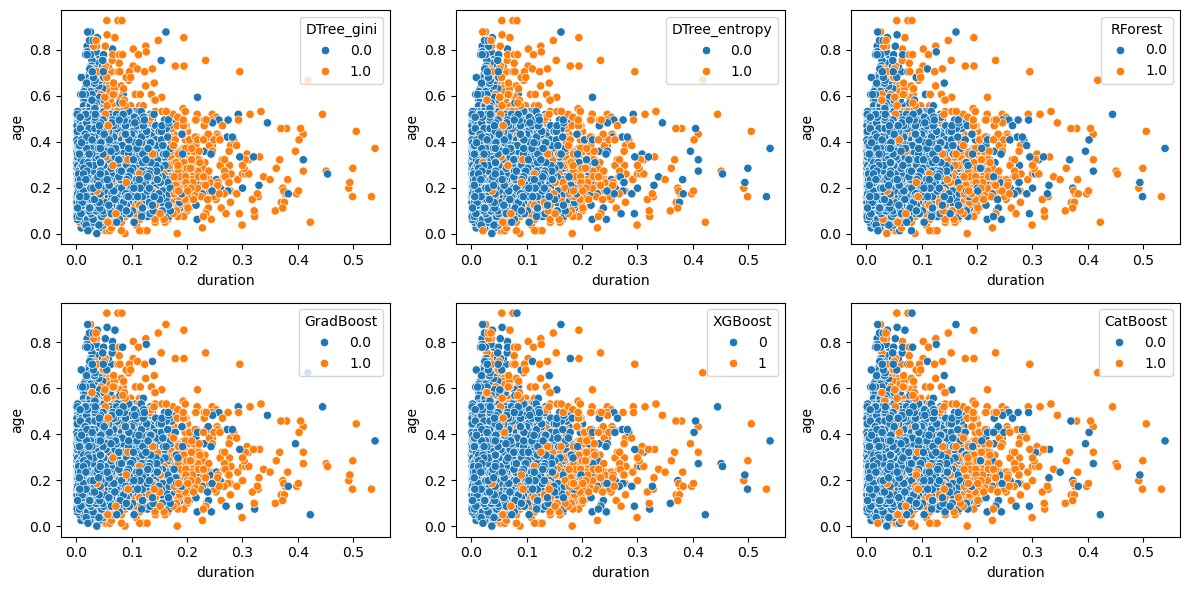

In [148]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "DTree_gini")

plt.subplot(2, 3, 2)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "DTree_entropy")

plt.subplot(2, 3, 3)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "RForest")

plt.subplot(2, 3, 4)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "GradBoost")

plt.subplot(2, 3, 5)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "XGBoost")

plt.subplot(2, 3, 6)
sns.scatterplot(data = test_data, x = "duration", y = "age", hue = "CatBoost")

plt.tight_layout()
plt.show()

Реализовать решение задачи заполнения пропусков с использованием деревьев решений. Сравнить с ранее применявшимися методами.

In [434]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [436]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [438]:
df.Cabin.mode()[2]

'G6'

In [440]:
df.Cabin = df.Cabin.fillna(df.Cabin.mode()[2])
df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

In [442]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

In [444]:
age_mode = int(df.Age.mode())
age_mode

24

In [446]:
age_mean = int(df.Age.mean())
age_mean

29

In [448]:
age_median = int(df.Age.median())
age_median

28

_mode_

In [451]:
df_mode = df.copy()
df_mode.Age = df_mode.Age.fillna(age_mode)
df_mode.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [453]:
X = df_mode.drop(['Survived', 'Sex', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
y = df_mode.Survived

In [455]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [457]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, min_samples_split=2)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(f'Decision Tree Classification Accuracy: {round(accuracy_score(y_test, tree_pred), 2)*100}')

svc_rbf = SVC(kernel = 'rbf', probability = True)
svc_rbf.fit(X_train, y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

print(f'SVC(rbf) Accuracy: {round(accuracy_score(y_test, svc_rbf_pred), 3)*100} %')

Decision Tree Classification Accuracy: 74.0
SVC(rbf) Accuracy: 67.0 %


_mean_

In [460]:
df_mean = df.copy()
df_mean.Age = df_mode.Age.fillna(age_mean)
df_mean.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [462]:
X = df_mean.drop(['Survived', 'Sex', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
y = df_mean.Survived

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [466]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, min_samples_split=2)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(f'Decision Tree Classification Accuracy: {round(accuracy_score(y_test, tree_pred), 2)*100}')

svc_rbf = SVC(kernel = 'rbf', probability = True)
svc_rbf.fit(X_train, y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

print(f'SVC(rbf) Accuracy: {round(accuracy_score(y_test, svc_rbf_pred), 3)*100} %')

Decision Tree Classification Accuracy: 74.0
SVC(rbf) Accuracy: 67.0 %


_median_

In [469]:
df_median = df.copy()
df_median.Age = df_mode.Age.fillna(age_median)
df_median.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [471]:
X = df_median.drop(['Survived', 'Sex', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1)
y = df_median.Survived

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [475]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, min_samples_split=2)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(f'Decision Tree Classification Accuracy: {round(accuracy_score(y_test, tree_pred), 2)*100}')

svc_rbf = SVC(kernel = 'rbf', probability = True)
svc_rbf.fit(X_train, y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

print(f'SVC(rbf) Accuracy: {round(accuracy_score(y_test, svc_rbf_pred), 3)*100} %')

Decision Tree Classification Accuracy: 74.0
SVC(rbf) Accuracy: 67.0 %


_full_

In [478]:
X = df.drop(['Survived', 'Sex', 'Cabin', 'Embarked', 'Name', 'Ticket','Age'], axis = 1)
y = df.Survived

In [480]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [482]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, min_samples_split=2)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(f'Decision Tree Classification Accuracy: {round(accuracy_score(y_test, tree_pred), 2)*100}')

svc_rbf = SVC(kernel = 'rbf', probability = True)
svc_rbf.fit(X_train, y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

print(f'SVC(rbf) Accuracy: {round(accuracy_score(y_test, svc_rbf_pred), 3)*100} %')

Decision Tree Classification Accuracy: 71.0
SVC(rbf) Accuracy: 67.0 %


Самостоятельно программно реализовать по крайней мере один из алгоритмов построения деревьев решений (ID3, C4.5, C5.0, CART).

In [5]:
df0 = pd.read_csv('PlayTennis.csv')

# Лямбда-выражение для распределения значений, аргумент - pandas.Series, 
# возвращаемое значение - массив с количеством каждого из значений
# Из вводных данных s с помощью value_counts() находим частоту каждого из значений, 
# и пока в нашем словаре есть элементы, будет работать цикл, запускаемый items().
# Чтобы выходные данные не менялись с каждым запуском цикла, мы используем sorted, 
# который меняет порядок от большего к меньшему
# В итоге, генерируется массив, содержащий строку из следующих компонентов: ключ (k) и значение (v).
cstr = lambda s:[k+":"+str(v) for k,v in sorted(s.value_counts().items())]
tree = {
    "name":"decision tree "+df0.columns[-1]+" "+str(cstr(df0.iloc[:,-1])),
    "df":df0,
    "edges":[],
}

open = [tree]

entropy = lambda s:-reduce(lambda x,y:x+y,map(lambda x:(x/len(s))*math.log2(x/len(s)),s.value_counts()))

while(len(open)!=0):
    n = open.pop(0)
    df_n = n["df"]
    
    # В случае, если энтропия этого узла равна 0, мы больше не можем вырастить из него новые ветви
    # поэтому прекращаем ветвление от этого узла
    if 0==entropy(df_n.iloc[:,-1]):
        continue
    
    attrs = {}
    
    for attr in df_n.columns[:-1]:
        # Создаем переменную, которая хранит значение энтропии при ветвлении с этим атрибутом,
        # данные после разветвления и значение атрибута, который разветвляется.
        attrs[attr] = {"entropy":0,"dfs":[],"values":[]}

        # Исследуем все возможные значения этого атрибута. 
        # Кроме того, sorted предназначен для предотвращения изменения порядка массива, 
        # из которого были удалены повторяющиеся значения атрибутов, при каждом его выполнении.
        for value in sorted(set(df_n[attr])):
            df_m = df_n.query(attr+"=='"+value+"'")
            attrs[attr]["entropy"] += entropy(df_m.iloc[:,-1])*df_m.shape[0]/df_n.shape[0]
            attrs[attr]["dfs"] += [df_m]
            attrs[attr]["values"] += [value]
            pass
        pass
    
    if len(attrs)==0:
        continue
    
    attr = min(attrs,key=lambda x:attrs[x]["entropy"])
    
    # Добавляем каждое значение разветвленного атрибута
    # и данные, полученные после разветвления, в наше дерево и в open.
    for d,v in zip(attrs[attr]["dfs"],attrs[attr]["values"]):
        m = {"name":attr+"="+v,"edges":[],"df":d.drop(columns=attr)}
        n["edges"].append(m)
        open.append(m)
    pass


print(df0,"\n-------------")
def tstr(tree,indent=""):
    s = indent+tree["name"]+str(cstr(tree["df"].iloc[:,-1]) if len(tree["edges"])==0 else "")+"\n"
    # Создаем символьное представление этого узла.
    # Если этот узел является листовым узлом (количество элементов в массиве ребер равно 0), 
    # частотное распределение последнего столбца данных df, связанных с деревом, преобразуется в символы.
    for e in tree["edges"]:
        s += tstr(e,indent+"  ")
        pass
    return s

print(tstr(tree))

     Outlook Temperature Humidity    Wind PlayTennis
0      Sunny         Hot     High    Weak         No
1      Sunny         Hot     High  Strong         No
2   Overcast         Hot     High    Weak        Yes
3       Rain        Mild     High    Weak        Yes
4       Rain        Cool   Normal    Weak        Yes
5       Rain        Cool   Normal  Strong         No
6   Overcast        Cool   Normal  Strong        Yes
7      Sunny        Mild     High    Weak         No
8      Sunny        Cool   Normal    Weak        Yes
9       Rain        Mild   Normal    Weak        Yes
10     Sunny        Mild   Normal  Strong        Yes
11  Overcast        Mild     High  Strong        Yes
12  Overcast         Hot   Normal    Weak        Yes
13      Rain        Mild     High  Strong         No 
-------------
decision tree PlayTennis ['No:5', 'Yes:9']
  Outlook=Overcast['Yes:4']
  Outlook=Rain
    Wind=Strong['No:2']
    Wind=Weak['Yes:3']
  Outlook=Sunny
    Humidity=High['No:3']
    Humidity=No